### Drowsiness detection Model

##### Import & Set pytorch device

In [1]:
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [2]:
import numpy as np
import pandas as pd

import os
import shutil

import random
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchsummary
from torch.utils.data import DataLoader, TensorDataset, random_split

from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder 

from tqdm import tqdm
import time
import copy

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print ('Current cuda device is', device)

Current cuda device is cuda


In [4]:
# train, validation, test split 6:2:2

original_dataset_dir = 'd:/drowsiness_dataset/Train'   
classes_list = os.listdir(original_dataset_dir) 
classes_list

transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()]) 
train_dataset = ImageFolder(root=original_dataset_dir, transform=transform_base) 

train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size

train_dat, validation_dat = random_split(train_dataset, [train_size, validation_size])

len(train_dat), len(validation_dat)

train_size = int(0.75 * len(train_dat))
test_size = len(train_dat) - train_size

train_dat, test_dat = random_split(train_dat, [train_size, test_size])

len(train_dat), len(validation_dat), len(test_dat)

(6000, 2000, 2000)

In [5]:
BATCH_SIZE=32
NUM_WORK=4

train_loader = DataLoader(dataset=train_dat,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORK,
                             shuffle=True)

val_loader = DataLoader(dataset=validation_dat,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORK,
                            shuffle=False)

In [6]:
first_batch = train_loader.__iter__().__next__()
# it = iter(train_loader)
# images, labels = next(it)

print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))

Num of Batch    |                           | 188
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([32, 3, 64, 64])


In [7]:
class_idx = train_dataset.class_to_idx
print(f"Index of clases are: {class_idx}")

class_names = list(class_idx)
print(f"\nClass Names are: {class_names}")

Index of clases are: {'Closed_Eyes': 0, 'Open_Eyes': 1}

Class Names are: ['Closed_Eyes', 'Open_Eyes']


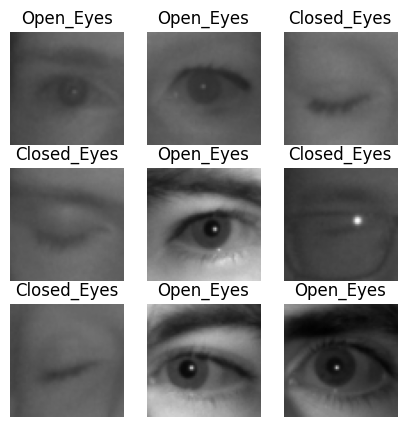

In [8]:
tmp = next(iter(train_loader))

plt.figure(figsize=(5, 5))
images = tmp[0]
labels = tmp[1]
for i in range(9):  # 9개의 이미지 출력
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)))
    plt.title(class_names[labels[i]])  # images에 해당하는 레이블 출력
    plt.axis("off")

##### Transfer Learning - ResNet50

In [9]:
###################### 전이학습 모델 불러오기
resnet = models.resnet50(pretrained=True)  

c:\Users\user\miniconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\miniconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# for param in resnet.parameters():
#     param.requires_grad = False


###################### 전이학습 모델의 일부 layer 동결
ct = 0 
for child in resnet.children():  
    ct += 1  
    if ct < 6: # 4층 이하는 동결시킴 (block1까지만)
        for param in child.parameters():
            param.requires_grad = False

In [10]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
    
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        # print('y_pred_class : ',y_pred_class)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [11]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_preds = model(X)

            loss = loss_fn(test_preds , y)
            test_loss += loss.item()

            test_pred_labels = test_preds.argmax(dim=1)
            # print('test_pred_labels : ', test_pred_labels)
            test_acc += ((test_pred_labels == y ).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [13]:
def training(model: torch.nn.Module,
            train_dataloader,
            test_dataloader,
            optimizer,
            loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
            epochs: int = 10, 
            device=device):
    
    results = {"train_loss":[],
               "train_acc":[],
               "test_loss":[],
               "test_acc":[]}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
    
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [14]:
###################### fc layer 구조 변경
num_ftrs = resnet.fc.in_features   
resnet.fc = nn.Linear(num_ftrs, 2) # fc를 nn.Linear(num_ftrs, 33)로 대체
resnet = resnet.to(device) # 출력층 확인
 
# loss_fn = nn.BCELoss().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)
 
# from torch.optim import lr_scheduler
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 

In [15]:
torchsummary.summary(resnet, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [16]:
EPOCHS = 5

from timeit import default_timer as timer
start_time = timer()

model_resnet50 = training(model=resnet,
                          train_dataloader=train_loader,
                          test_dataloader=val_loader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=EPOCHS,
                          device=device)

end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:20<03:08, 20.94s/it]

Epoch: 0 | Train loss: 0.0347 | Train acc: 0.9890 | Test loss: 0.0126 | Test acc: 0.9975


 20%|██        | 2/10 [00:41<02:43, 20.50s/it]

Epoch: 1 | Train loss: 0.0192 | Train acc: 0.9948 | Test loss: 0.0010 | Test acc: 1.0000


 30%|███       | 3/10 [01:01<02:23, 20.54s/it]

Epoch: 2 | Train loss: 0.0045 | Train acc: 0.9990 | Test loss: 0.0023 | Test acc: 0.9995


 40%|████      | 4/10 [01:22<02:03, 20.57s/it]

Epoch: 3 | Train loss: 0.0058 | Train acc: 0.9982 | Test loss: 0.0004 | Test acc: 1.0000


 50%|█████     | 5/10 [01:42<01:42, 20.50s/it]

Epoch: 4 | Train loss: 0.0001 | Train acc: 1.0000 | Test loss: 0.0013 | Test acc: 0.9990


 60%|██████    | 6/10 [02:03<01:22, 20.53s/it]

Epoch: 5 | Train loss: 0.0069 | Train acc: 0.9983 | Test loss: 0.0057 | Test acc: 0.9985


 70%|███████   | 7/10 [02:23<01:01, 20.55s/it]

Epoch: 6 | Train loss: 0.0056 | Train acc: 0.9985 | Test loss: 0.0006 | Test acc: 0.9995


 80%|████████  | 8/10 [02:44<00:41, 20.63s/it]

Epoch: 7 | Train loss: 0.0011 | Train acc: 0.9997 | Test loss: 0.0006 | Test acc: 0.9995


 90%|█████████ | 9/10 [03:05<00:20, 20.62s/it]

Epoch: 8 | Train loss: 0.0019 | Train acc: 0.9997 | Test loss: 0.0000 | Test acc: 1.0000


100%|██████████| 10/10 [03:25<00:00, 20.57s/it]

Epoch: 9 | Train loss: 0.0001 | Train acc: 1.0000 | Test loss: 0.0000 | Test acc: 1.0000
Total training time: 205.685 seconds


### Save Model & Test

In [17]:
# resnet.state_dict()
torch.save(resnet.state_dict(), 'drowsiness_detect_state_dict.pt')

In [18]:
torch.save(resnet, 'drowsiness_detect.pt')

# resnet50=torch.load('drowsiness_detect.pt') 
# print(resnet50)

In [12]:
test_loader = DataLoader(dataset=test_dat,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORK,
                            shuffle=False)

In [14]:
model = torch.load('drowsiness_detect.pt')
model.load_state_dict(torch.load('drowsiness_detect_state_dict.pt')) 

model.eval()

loss_fn = nn.CrossEntropyLoss().to(device)

test_loss, test_accuracy = test_step(model, test_loader, loss_fn=loss_fn)
print('ResNet test acc:  ', test_accuracy)

ResNet test acc:   1.0


tensor([[[[0.4980, 0.5059, 0.5020,  ..., 0.5176, 0.5059, 0.4902],
          [0.5098, 0.5059, 0.5059,  ..., 0.5176, 0.5098, 0.4902],
          [0.5020, 0.5059, 0.5098,  ..., 0.5137, 0.5098, 0.4902],
          ...,
          [0.5333, 0.5451, 0.5490,  ..., 0.6275, 0.6157, 0.6039],
          [0.5255, 0.5373, 0.5529,  ..., 0.6235, 0.6118, 0.6078],
          [0.5294, 0.5373, 0.5451,  ..., 0.6196, 0.6039, 0.6000]],

         [[0.4980, 0.5059, 0.5020,  ..., 0.5176, 0.5059, 0.4902],
          [0.5098, 0.5059, 0.5059,  ..., 0.5176, 0.5098, 0.4902],
          [0.5020, 0.5059, 0.5098,  ..., 0.5137, 0.5098, 0.4902],
          ...,
          [0.5333, 0.5451, 0.5490,  ..., 0.6275, 0.6157, 0.6039],
          [0.5255, 0.5373, 0.5529,  ..., 0.6235, 0.6118, 0.6078],
          [0.5294, 0.5373, 0.5451,  ..., 0.6196, 0.6039, 0.6000]],

         [[0.4980, 0.5059, 0.5020,  ..., 0.5176, 0.5059, 0.4902],
          [0.5098, 0.5059, 0.5059,  ..., 0.5176, 0.5098, 0.4902],
          [0.5020, 0.5059, 0.5098,  ..., 0

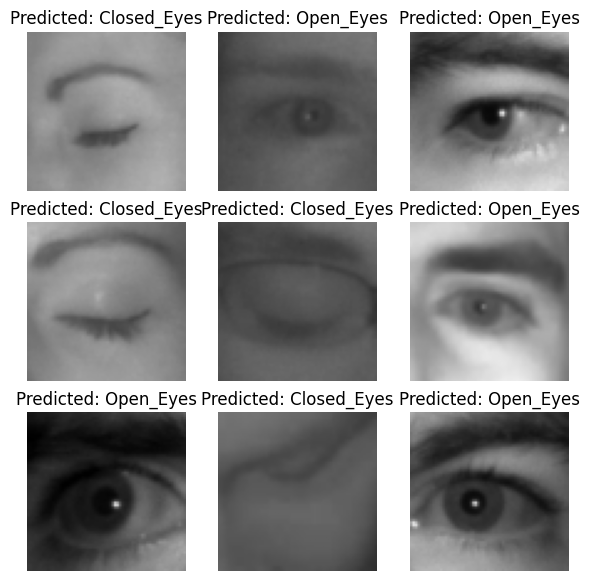

In [26]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model
model = torch.load('drowsiness_detect.pt')
model.load_state_dict(torch.load('drowsiness_detect_state_dict.pt')) 

model.eval()

tmp = next(iter(test_loader))

plt.figure(figsize=(7, 7))
images = tmp[0]
labels = tmp[1]

for i in range(9):
    ax = plt.subplot(3,3,i+1)

    image = images[i].unsqueeze(0).to(device)
    print(image)
    print(image.shape)
    
    test_preds = model(image)
    print(test_preds)
    print('----------------------------------------------------------------------')

    # predicted class index (argmax)
    predicted_class_idx = torch.argmax(test_preds, dim=1)
    
    # predicted class label based on index
    predicted_class_label = class_names[predicted_class_idx.item()]
    
    plt.imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # Assuming my image format is CxHxW (channel-first)
    plt.title(f"Predicted: {predicted_class_label}")
    plt.axis('off')

plt.show()

tensor([[[[0.6863, 0.6941, 0.6902,  ..., 0.7373, 0.7373, 0.7412],
          [0.7020, 0.7020, 0.7020,  ..., 0.7412, 0.7451, 0.7412],
          [0.7059, 0.7059, 0.7059,  ..., 0.7412, 0.7451, 0.7490],
          ...,
          [0.7647, 0.7647, 0.7686,  ..., 0.8078, 0.8039, 0.8039],
          [0.7647, 0.7647, 0.7686,  ..., 0.8118, 0.8078, 0.8039],
          [0.7647, 0.7647, 0.7686,  ..., 0.8118, 0.8078, 0.8078]],

         [[0.6863, 0.6941, 0.6902,  ..., 0.7373, 0.7373, 0.7412],
          [0.7020, 0.7020, 0.7020,  ..., 0.7412, 0.7451, 0.7412],
          [0.7059, 0.7059, 0.7059,  ..., 0.7412, 0.7451, 0.7490],
          ...,
          [0.7647, 0.7647, 0.7686,  ..., 0.8078, 0.8039, 0.8039],
          [0.7647, 0.7647, 0.7686,  ..., 0.8118, 0.8078, 0.8039],
          [0.7647, 0.7647, 0.7686,  ..., 0.8118, 0.8078, 0.8078]],

         [[0.6863, 0.6941, 0.6902,  ..., 0.7373, 0.7373, 0.7412],
          [0.7020, 0.7020, 0.7020,  ..., 0.7412, 0.7451, 0.7412],
          [0.7059, 0.7059, 0.7059,  ..., 0

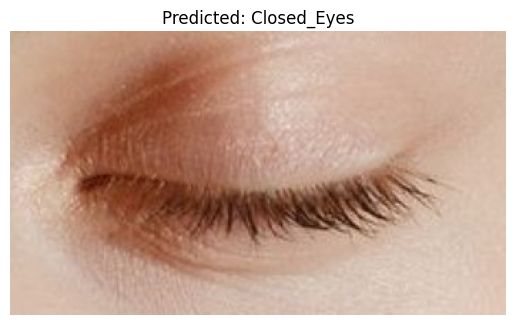

In [35]:
import cv2

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

# 이미지 불러오기 - cv로 보기
image = Image.open('d:/drowsiness_video_data/image/test4.jpg')
imageorg = image.copy()
image = transform(image).to(device)
image = image.unsqueeze(0)
print(image)
print(image.shape)

test_preds = model(image)
print(test_preds)

predicted_class_idx = torch.argmax(test_preds, dim=1)
predicted_class_label = class_names[predicted_class_idx.item()]
# plt.imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))

plt.imshow(imageorg)
plt.title(f"Predicted: {predicted_class_label}")
plt.axis('off')
plt.show()

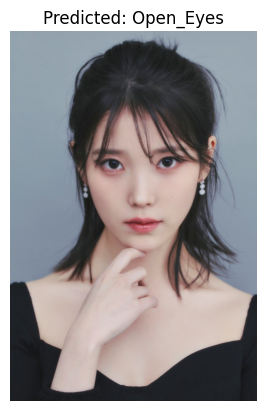

In [15]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# 이미지 불러오기 - cv로 보기
image = Image.open('d:/test_open_eyes.jpg')
imageorg = image.copy()
image = transform(image).to(device)
image = image.unsqueeze(0)

test_preds = model(image)
predicted_class_idx = torch.argmax(test_preds, dim=1)
predicted_class_label = class_names[predicted_class_idx.item()]
# plt.imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))

plt.imshow(imageorg)
plt.title(f"Predicted: {predicted_class_label}")
plt.axis('off')
plt.show()

### Confusion Matrix

Text(45.722222222222214, 0.5, 'true label')

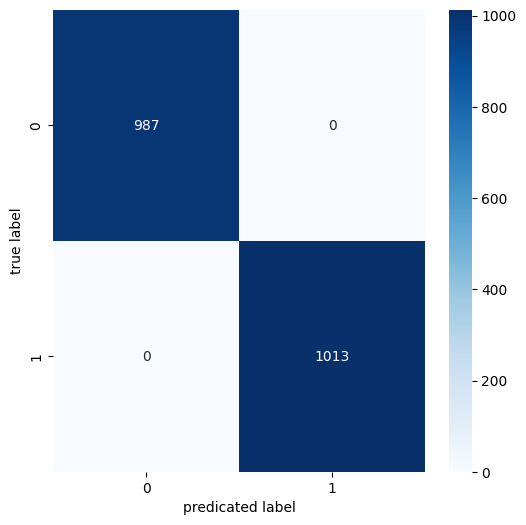

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

y_pred = []
y_true = []

for batch, (image,label) in enumerate(test_loader):
    image, label = image.to(device), label.to(device)

    test_preds = model(image)
    # test_pred_labels = test_preds.argmax(dim=1)
    output = (torch.max(torch.exp(test_preds), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)

    labels = label.data.cpu().numpy()
    y_true.extend(labels)


cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix

df_cm = pd.DataFrame(cf_matrix,
                     index = [i for i in class_names],
                     columns = [i for i in class_names])
df_cm

plt.figure(figsize=(6,6))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

# plt.figure(figsize = (12,7))
# sns.heatmap(df_cm, annot=True)